In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import numpy as np
from tqdm import tqdm
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
train_transforms = A.Compose([
    A.Normalize (mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    #A.ShiftScaleRotate(shift_limit = 0.2, scale_limit = 0.1, rotate_limit = 15,p=0.4),
    A.HorizontalFlip(),
    A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
    A.RandomCrop(height=32, width=32, always_apply=True),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, fill_value=0, mask_fill_value=None, always_apply=False, p=0.5),
    ToTensorV2()
])

#Test Phase transformations
test_transforms = A.Compose([A.Normalize (mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
                             ToTensorV2()
                                       ])

In [3]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:02<00:00, 83750187.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
class CFAR_Resnet_Custom(nn.Module):
  def __init__(self):
    super(CFAR_Resnet_Custom, self).__init__()

        # Prep Layer
    self.prep_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1,stride=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU())
    # ************************************* Layer 1 ********************************
    # Layer 1
    self.lyr1 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1,stride=1, bias=False),
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(128),
        nn.ReLU())

    # Res Block 1
    self.res1= nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1,stride=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1,stride=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1,stride=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU())

    # ************************************** Layer 2 *********************************
    # Layer 2
    self.lyr2 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1,stride=1, bias=False),
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(256),
        nn.ReLU())

    # ************************************** Layer 3 **********************************
    # Layer 3

    self.lyr3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1,stride=1, bias=False),
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(512),
        nn.ReLU())

    self.res2 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1,stride=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1,stride=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1,stride=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU())
    # ************************************ Max Pool Layer *******************************

    self.maxpool = nn.MaxPool2d(kernel_size=4, stride=2)


    # ************************************ FC Layer *************************************
    self.fc=nn.Sequential(
      nn.Linear(1*1*512,40),
      nn.Linear(40,10))



  def forward(self, x):
      x = self.prep_layer(x) # O/P SIZE - 32
      x = self.lyr1(x) # O/P SIZE - 16
      R1= self.res1(x) # O/P SIZE - 16
      x = x+ R1 # O/P SIZE - 16
      x = self.lyr2(x) # O/P SIZE - 8
      x = self.lyr3(x) # O/P Sixe - 4
      R2= self.res2(x) # O/P Size - 4
      x = x + R2 # O/P Size - 8
      x=  self.maxpool(x) # O/P Size -3
      x = x.view(-1, 1*1*512)
      x = self.fc(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [6]:
x = torch.randn(1,3,32,32)
model=CFAR_Resnet_Custom()
for layer in model.prep_layer:
  x = layer(x)
  print (layer)
  print(x.size())
  print (type(x))

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([1, 64, 32, 32])
<class 'torch.Tensor'>
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([1, 64, 32, 32])
<class 'torch.Tensor'>
ReLU()
torch.Size([1, 64, 32, 32])
<class 'torch.Tensor'>


In [7]:
# Model Summary
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CFAR_Resnet_Custom().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [8]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.30E-02


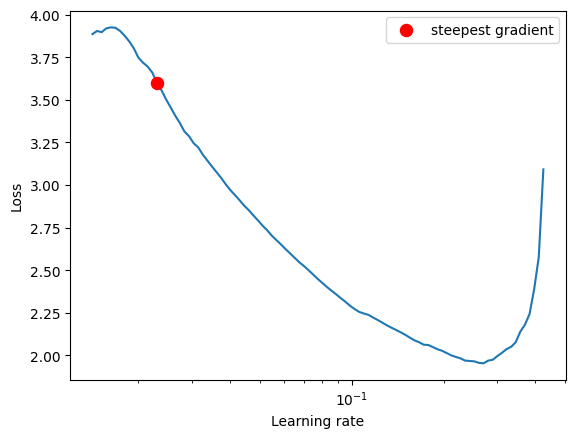

In [9]:
! pip install torch_lr_finder
from torch_lr_finder import LRFinder

model = CFAR_Resnet_Custom().to(device)
optimizer=optim.Adam(model.parameters(),lr=1e-2,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
Lr_Finder=LRFinder(model,optimizer,criterion,device='cuda')
Lr_Finder.range_test(train_loader,end_lr=10,num_iter=200,step_mode='exp')
Lr_Finder.plot()
Lr_Finder.reset()

In [10]:
from torch.optim.lr_scheduler import OneCycleLR
#model = CFAR_Resnet_Custom().to(device)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
EPOCHS = 24

scheduler = OneCycleLR(optimizer,
                       max_lr=2.47E-02,
                       steps_per_epoch=len(train_loader),
                       epochs=EPOCHS,
                       pct_start=5/EPOCHS,
                       div_factor=100,
                       three_phase=False,
                       final_div_factor=100,
                       anneal_strategy='linear')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader)
    scheduler.step()


EPOCH: 0


Train: Loss=1.0323 Batch_id=97 Accuracy=50.78: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]


Test set: Average loss: 1.0501, Accuracy: 6233/10000 (62.33%)

EPOCH: 1


Train: Loss=0.7438 Batch_id=97 Accuracy=67.74: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]


Test set: Average loss: 0.8811, Accuracy: 6818/10000 (68.18%)

EPOCH: 2


Train: Loss=0.7293 Batch_id=97 Accuracy=74.97: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]


Test set: Average loss: 0.7194, Accuracy: 7538/10000 (75.38%)

EPOCH: 3


Train: Loss=0.6043 Batch_id=97 Accuracy=79.31: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.5405, Accuracy: 8165/10000 (81.65%)

EPOCH: 4


Train: Loss=0.4621 Batch_id=97 Accuracy=82.33: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]


Test set: Average loss: 0.5024, Accuracy: 8291/10000 (82.91%)

EPOCH: 5


Train: Loss=0.4064 Batch_id=97 Accuracy=83.91: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]


Test set: Average loss: 0.5627, Accuracy: 8065/10000 (80.65%)

EPOCH: 6


Train: Loss=0.4278 Batch_id=97 Accuracy=85.56: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]


Test set: Average loss: 0.5392, Accuracy: 8214/10000 (82.14%)

EPOCH: 7


Train: Loss=0.3752 Batch_id=97 Accuracy=86.45: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]


Test set: Average loss: 0.4287, Accuracy: 8554/10000 (85.54%)

EPOCH: 8


Train: Loss=0.2778 Batch_id=97 Accuracy=87.75: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.4292, Accuracy: 8501/10000 (85.01%)

EPOCH: 9


Train: Loss=0.2639 Batch_id=97 Accuracy=88.54: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]


Test set: Average loss: 0.4071, Accuracy: 8594/10000 (85.94%)

EPOCH: 10


Train: Loss=0.2695 Batch_id=97 Accuracy=89.40: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]


Test set: Average loss: 0.4020, Accuracy: 8677/10000 (86.77%)

EPOCH: 11


Train: Loss=0.3425 Batch_id=97 Accuracy=89.95: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]


Test set: Average loss: 0.4425, Accuracy: 8532/10000 (85.32%)

EPOCH: 12


Train: Loss=0.2885 Batch_id=97 Accuracy=90.49: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]


Test set: Average loss: 0.6239, Accuracy: 8153/10000 (81.53%)

EPOCH: 13


Train: Loss=0.2569 Batch_id=97 Accuracy=90.56: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]


Test set: Average loss: 0.4153, Accuracy: 8627/10000 (86.27%)

EPOCH: 14


Train: Loss=0.2665 Batch_id=97 Accuracy=90.84: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]


Test set: Average loss: 0.5790, Accuracy: 8300/10000 (83.00%)

EPOCH: 15


Train: Loss=0.2132 Batch_id=97 Accuracy=91.69: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]


Test set: Average loss: 0.3730, Accuracy: 8816/10000 (88.16%)

EPOCH: 16


Train: Loss=0.2741 Batch_id=97 Accuracy=92.10: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]


Test set: Average loss: 0.4940, Accuracy: 8507/10000 (85.07%)

EPOCH: 17


Train: Loss=0.1975 Batch_id=97 Accuracy=92.11: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.4864, Accuracy: 8520/10000 (85.20%)

EPOCH: 18


Train: Loss=0.2476 Batch_id=97 Accuracy=92.37: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.4248, Accuracy: 8667/10000 (86.67%)

EPOCH: 19


Train: Loss=0.1607 Batch_id=97 Accuracy=92.31: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]


Test set: Average loss: 0.3944, Accuracy: 8749/10000 (87.49%)

EPOCH: 20


Train: Loss=0.3158 Batch_id=97 Accuracy=92.54: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.5721, Accuracy: 8231/10000 (82.31%)

EPOCH: 21


Train: Loss=0.1954 Batch_id=97 Accuracy=92.68: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]


Test set: Average loss: 0.3601, Accuracy: 8864/10000 (88.64%)

EPOCH: 22


Train: Loss=0.1891 Batch_id=97 Accuracy=92.97: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.3875, Accuracy: 8824/10000 (88.24%)

EPOCH: 23


Train: Loss=0.2263 Batch_id=97 Accuracy=93.14: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.3431, Accuracy: 8934/10000 (89.34%)

